# Tree-Cluster States

In [12]:
import numpy as np
import qiskit.providers.aer.noise as noise
import matplotlib.pyplot as plt
# plt.style.use('paper.mplstyle')
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, transpile, execute
from qiskit.quantum_info import DensityMatrix, state_fidelity
from qiskit.visualization import plot_histogram

In [2]:
# Return number of qubits of a TCS given a branching vector
def find_n_qubits(branch_vector):
    n_qubits = 1
    for i in range(1, len(branch_vector) + 1, 1):
        n_qubits += np.product(branch_vector[0:i])
    return n_qubits

# Make Tree-Cluster State with message qubit
def make_TCS(branch_vector):
    n_qubits = find_n_qubits(branch_vector)
    global qr, cr
    qr = QuantumRegister(n_qubits + 1, 'q')
    cr = ClassicalRegister(6, 'c')
    circ = QuantumCircuit(qr, cr)
    # Apply Hadamard to each qubit in the TCS
    for q in range(1, n_qubits + 1):
        circ.h(q)
    # Create first layer of TCS
    for k in range(2, 2 + branch_vector[0]):
        circ.cz(1, k)
    # Stop if there is only one layer
    if len(branch_vector) == 1:
        return circ
    # Create remaining layers
    qubit_counter = 2
    for layer in range(len(branch_vector)):
        if layer + 1 == len(branch_vector):
            break
        qubits_in_layer = np.product(branch_vector[0:layer + 1])
        children = -1
        for qubit in range(qubits_in_layer): 
            for child in range(branch_vector[layer + 1]):
                children += 1
                circ.cz(qubit_counter + qubit, qubit_counter + qubits_in_layer + children)
    return circ

In [3]:
def reconstruct_state(z_counts, x_counts):
    """
    Given histograms for x and z measurements, 
    reconstructs the state. 
    """
    def get_basis_ratio(counts):
        if '0' not in counts.keys():
            return (0, 1)
        elif '1' not in counts.keys():
            return (1, 0)
        else:
            total = counts['0'] + counts['1']
            return (counts['0'] / total, counts['1'] / total)
        
    z_ratio = get_basis_ratio(z_counts)
    z_exp = z_ratio[0] - z_ratio[1]
    
    x_ratio = get_basis_ratio(x_counts)
    x_exp = x_ratio[0] - x_ratio[1]
    
    ysq = 1 - z_exp * z_exp - x_exp * x_exp
    if ysq < 0:
        y_exp = 0
    else:
        y_exp = np.sqrt(ysq)
    
    # Return position on the Bloch sphere
    pos = np.array([x_exp, y_exp, z_exp])
    return pos / np.linalg.norm(pos)

def bloch_to_dm(vec):
    """
    Takes in a 3-tuple corresponding to a position 
    on the Bloch sphere and returns a density matrix.
    """
    identity = np.array([[1, 0], [0, 1]])
    sigmax = np.array([[0, 1], [1, 0]])
    sigmay = np.array([[0, -1j], [1j, 0]])
    sigmaz = np.array([[1, 0], [0, -1]])
    return 1/2 * (identity + vec[0] * sigmax + vec[1] * sigmay + vec[2] * sigmaz)

def state_vec(theta, direction):
    circ = QuantumCircuit(1)
    if direction == 'z':
        circ.h(0)
        circ.p(theta, 0)
    if direction == 'x':
        circ.h(0)
        circ.p(-theta, 0)
        circ.h(0)
    if direction == 'y':
        circ.sdg(0); circ.h(0)
        circ.p(theta, 0)
        circ.h(0); circ.s(0)
    return Statevector(circ)

def get_fidelity(theta, direction):
    if direction == 'z':
        meas_state = reconstruct_state(counts_z_filtered[theta, 'z'], counts_z_filtered[theta, 'x'])
    if direction == 'x':
        meas_state = reconstruct_state(counts_x_filtered[theta, 'z'], counts_x_filtered[theta, 'x'])
    if direction == 'y':
        meas_state = reconstruct_state(counts_y_filtered[theta, 'z'], counts_y_filtered[theta, 'x'])
    meas_dm = DensityMatrix(bloch_to_dm(meas_state))
    true_state = state_vec(theta, direction)
    return state_fidelity(meas_dm, true_state)

## Quantum One-Way Repeater Protocol

In [4]:
def make_repeater_circuit(state, measure_dir):
    # Initialize the circuit
    circ = make_TCS([2, 2])
    circ.barrier()

    # Add message and entangle with root qubit
    circ.initialize(state, 0)
    circ.cx(0, 1)
    circ.h(0)
    # Store x1 in cbit 0, x2 in cbit 1
    circ.measure(0, 3)
    circ.measure(1, 4)
    circ.barrier()

    # Store x3 in cbit 2
    circ.measure(2, 2)
    circ.barrier()

    # Measure 2nd level qubits of branch 2 in z
    circ.measure(6, 1)
    circ.measure(7, 0)

    # Apply unitaries based on measurements
    circ.h(3).c_if(cr, 0)
    circ.h(3).c_if(cr, 3)
    circ.h(3).c_if(cr, 12)
    circ.h(3).c_if(cr, 15)
    circ.h(3).c_if(cr, 17)
    circ.h(3).c_if(cr, 18)
    circ.h(3).c_if(cr, 29)
    circ.h(3).c_if(cr, 30)

    circ.z(3).c_if(cr, 1); circ.h(3).c_if(cr, 1)
    circ.z(3).c_if(cr, 2); circ.h(3).c_if(cr, 2)
    circ.z(3).c_if(cr, 13); circ.h(3).c_if(cr, 13)
    circ.z(3).c_if(cr, 14); circ.h(3).c_if(cr, 14)
    circ.z(3).c_if(cr, 16); circ.h(3).c_if(cr, 16)
    circ.z(3).c_if(cr, 19); circ.h(3).c_if(cr, 19)
    circ.z(3).c_if(cr, 28); circ.h(3).c_if(cr, 28)
    circ.z(3).c_if(cr, 31); circ.h(3).c_if(cr, 31)

    circ.h(3).c_if(cr, 4); circ.z(3).c_if(cr, 4)
    circ.h(3).c_if(cr, 7); circ.z(3).c_if(cr, 7)
    circ.h(3).c_if(cr, 8); circ.z(3).c_if(cr, 8)
    circ.h(3).c_if(cr, 11); circ.z(3).c_if(cr, 11)
    circ.h(3).c_if(cr, 21); circ.z(3).c_if(cr, 21)
    circ.h(3).c_if(cr, 22); circ.z(3).c_if(cr, 22)
    circ.h(3).c_if(cr, 25); circ.z(3).c_if(cr, 25)
    circ.h(3).c_if(cr, 26); circ.z(3).c_if(cr, 26)

    circ.z(3).c_if(cr, 5); circ.h(3).c_if(cr, 5); circ.z(3).c_if(cr, 5)
    circ.z(3).c_if(cr, 6); circ.h(3).c_if(cr, 6); circ.z(3).c_if(cr, 6)
    circ.z(3).c_if(cr, 9); circ.h(3).c_if(cr, 9); circ.z(3).c_if(cr, 9)
    circ.z(3).c_if(cr, 10); circ.h(3).c_if(cr, 10); circ.z(3).c_if(cr, 10)
    circ.z(3).c_if(cr, 20); circ.h(3).c_if(cr, 20); circ.z(3).c_if(cr, 20)
    circ.z(3).c_if(cr, 23); circ.h(3).c_if(cr, 23); circ.z(3).c_if(cr, 23)
    circ.z(3).c_if(cr, 24); circ.h(3).c_if(cr, 24); circ.z(3).c_if(cr, 24)
    circ.z(3).c_if(cr, 27); circ.h(3).c_if(cr, 27); circ.z(3).c_if(cr, 27)

    # Measure the encoded qubit
    circ.barrier()
    if measure_dir == 'z':
        circ.measure(3, 5)
    if measure_dir == 'x':
        circ.h(3)
        circ.measure(3, 5)
    return circ

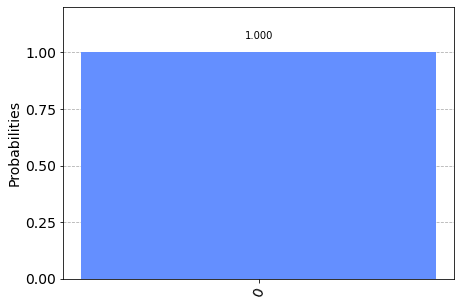

In [5]:
# Run the circuit
circ = make_repeater_circuit([1, 0], 'z')
backend = Aer.get_backend('qasm_simulator')
job = backend.run(transpile(circ, backend), shots=10000)
res = job.result()
counts = res.get_counts(circ)

# Get results from the last measurement
measurement = {}
measurement['0'] = sum([val for key, val in counts.items() if key[0] == '0'])
measurement['1'] = sum([val for key, val in counts.items() if key[0] == '1'])
measurement = {key : val for key, val in measurement.items() if val > 0}
plot_histogram(measurement)

## Using Multiple Repeaters

In [6]:
# Run the circuit
def run_circuit(circ, p_err1, p_err2):
    # Depolarizing quantum errors
    error_1 = noise.depolarizing_error(p_err1, 1)
    error_2 = noise.depolarizing_error(p_err2, 2)

    # Add errors to noise model
    noise_model = noise.NoiseModel()
    noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
    noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

    # Get basis gates from noise model
    basis_gates = noise_model.basis_gates
    
    # Run the thing
    backend = Aer.get_backend('qasm_simulator')
    res = execute(circ, backend, basis_gates=basis_gates, noise_model=noise_model).result()
    counts = res.get_counts(circ)
    # Get results from the last measurement
    measurement = {}
    measurement['0'] = sum([val for key, val in counts.items() if key[0] == '0'])
    measurement['1'] = sum([val for key, val in counts.items() if key[0] == '1'])
    return measurement


# Run the protocol some n_rep number of times with a given state
def run_protocol(n_rep, init_state, p_err1, p_err2):
    for n in range(n_rep):
        if n == 0:
            state = init_state
        circ_z = make_repeater_circuit(state, 'z')
        circ_x = make_repeater_circuit(state, 'x')
        measurement_z = run_circuit(circ_z, p_err1, p_err2)
        measurement_x = run_circuit(circ_x, p_err1, p_err2)
        res_dm = bloch_to_dm(reconstruct_state(measurement_z, measurement_x))
        res_dm = DensityMatrix(res_dm)
        state = res_dm.to_statevector()
    return state_fidelity(init_state, state)

In [8]:
# Initialize arrays
n_repeaters = np.array([1, 2, 4, 6, 8, 10])
p_errors = np.linspace(0, 1, 50)
fidelities = {n_rep : [] for n_rep in n_repeaters}

# Run the protocol for each parameter
state = [1, 0]
for n_rep in n_repeaters:
    for p_err in p_errors:
        fidelities[n_rep].append(run_protocol(n_rep, state, p_err, 0))

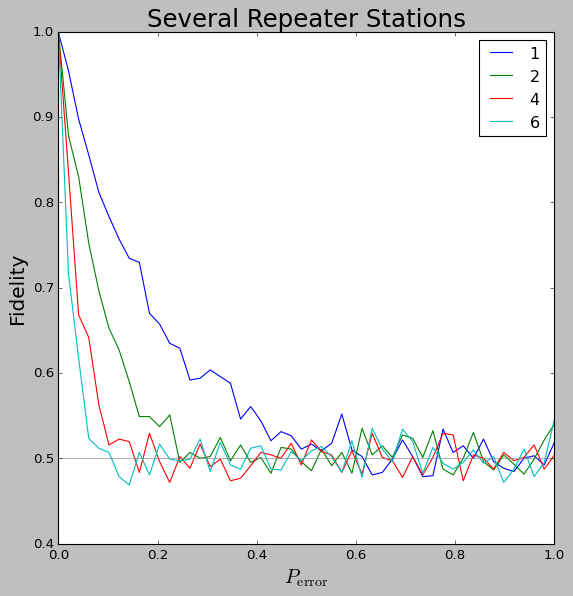

In [18]:
# Plot the results
counter = 0
for key, val in fidelities.items():
    counter += 1
    if counter <= 4:
        plt.plot(p_errors, val, label=key)
plt.axhline(y=0.5, color='gray', alpha=0.6)
plt.ylim((0.4, 1))
plt.rcParams['figure.figsize'] = (8, 8)
plt.xlabel(r'$P_{\rm{error}}$', fontsize=18)
plt.ylabel('Fidelity', size=18)
plt.title('Several Repeater Stations', fontsize=22)
plt.legend()
plt.show()